## **This notebook scrapes the stock recommendation from Yahoo Finance**

Author     : Willy LAO

Inspired by: https://github.com/mariostoev/finviz

Last update: 03/07/2020
---


# Install and import the useful librairies

In [ ]:
!pip install finviz
!pip install yahoo_fin --upgrade
!pip install requests-html
!pip install fake-useragent
!pip install xlsxwriter

     |████████████████████████████████| 1.2MB 4.1MB/s 
     |████████████████████████████████| 256kB 17.9MB/s 
     |████████████████████████████████| 153kB 13.0MB/s 
  Created wheel for finviz: filename=finviz-1.3.4-cp36-none-any.whl size=15192 sha256=f36192d1c63630e422c45b4d3442630690dbce17c1a776874e762da79afdceac
  Stored in directory: /root/.cache/pip/wheels/6d/fa/7c/4cc075d8af3f8ed083dd112b1a2b09888b9a9a2964c907291f
  Created wheel for user-agent: filename=user_agent-0.1.9-cp36-none-any.whl size=18807 sha256=10e7c7f13da02a15ed57e453f4115523839509d6d684994be740cdf6883129f5
  Stored in directory: /root/.cache/pip/wheels/92/80/3f/5d79277825042f2d4d447f594e3fc046f1e506f2b481d364b2
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3162 sha256=4fbf507019ebc5163b5ff06d6011963af855f3077e18c4f4a8c4353bb4d3f265
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built finviz user-agent idna-ssl
  

     |████████████████████████████████| 143kB 2.8MB/s 


In [ ]:
import pandas as pd 
import numpy as np
from decimal import Decimal
from tqdm import tqdm
from finviz.screener import Screener
from yahoo_fin import stock_info as si 
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import pandas as pd
import time
import bs4
import random
import requests
from fake_useragent import UserAgent
import itertools as it
from bs4 import BeautifulSoup
import xlrd
from pathlib import Path

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Mount Google Drive and load the parameters in Gurufocus Financials

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
# Load the Excel file containing all the parameters in Gurufocus Financials
gurufocus_financials_parameters = pd.read_excel(r'/content/drive/My Drive/Investing/Stock investing/Ressources/Gurufocus parameters.xlsx', sheet_name='Financials')

In [ ]:
  parameters          = list(gurufocus_financials_parameters['Parameter'])
  tag_of_parameters   = list(gurufocus_financials_parameters['Tag of parameter'])
  class_of_parameters = list(gurufocus_financials_parameters['Class of parameter'])
  tag_of_values       = list(gurufocus_financials_parameters['Tag of value'])
  class_of_values     = list(gurufocus_financials_parameters['Class of value'])

# DEFINE useful functions

In [ ]:
# Retrieve the tables from Finviz

def stock_df_from_list_tickers(recommendations_filter):

  stock_list          = {}
  all_stocks_screener = {}
  tables = ['Overview', 'Valuation', 'Financial', 'Ownership', 'Performance', 'Technical']
  for table in tqdm(tables):
    all_stocks_screener = Screener(table=table)
    stock_list[table] = pd.DataFrame(columns=list(all_stocks_screener[0].keys()))
    for stock_screener in all_stocks_screener:
      if stock_screener['Ticker'] in list(recommendations_filter['Company']):
        stock_list[table].loc[stock_screener['Ticker']] = stock_screener

  # Transform the type Screener into a dataframe
  stock_dict = {}
  stock_df = []
  for table in tables:
    df = pd.DataFrame.from_dict(stock_list[table]).T
    stock_df.append(df.T)

  return(stock_df, tables)

In [ ]:
# Retrieve the tables from Finviz

def stock_df_from_industry_screener(filters):

  # Retrieve the tables from Finviz
  stock_list = {}

  tables = ['Overview', 'Valuation', 'Financial', 'Ownership', 'Performance', 'Technical']
  for table in tqdm(tables):
    stock_list[table] = Screener(filters=filters, table=table)

  # Transform the type Screener into a dataframe
  stock_dict = {}
  stock_df = []
  for table in tables:
    for stock in stock_list[table]:
      stock_dict[stock['Ticker']] = stock
    stock_df.append(pd.DataFrame.from_dict(stock_dict).T)
  return(stock_df, tables)

In [ ]:
def concatenate_list_data(liste):
  if len(liste) == 0:
    return([])
  else:
    result= liste[0]
    for i in range(1, len(liste)):
        result += ' ' + str(liste[i])
    return result

In [ ]:
# Scrape gurufocus

def scrape_gurufocus_financials(gurufocus_financials_parameters, stock_df, tables):

  # Extract the parameters of the table Financials from the Excel file Gurufocus Parameters
  parameters          = list(gurufocus_financials_parameters['Parameter'])
  tag_of_parameters   = list(gurufocus_financials_parameters['Tag of parameter'])
  class_of_parameters = list(gurufocus_financials_parameters['Class of parameter'])
  tag_of_values       = list(gurufocus_financials_parameters['Tag of value'])
  class_of_values     = list(gurufocus_financials_parameters['Class of value'])

  # Create a dataframe whose columns are all the data to scrape from gurufocus Financials
  df_to_append = pd.DataFrame(columns=parameters)
  nb_stocks    = len(stock_df[0])

  # URL link to gurufocus Financials
  token = 'https://www.gurufocus.com/financials/'

  # For each stock symbol, retrieve the HTML code as a BeautifulSoup component
  for j in tqdm(range(nb_stocks)):
    # Retrieve the stock symbol in the table 'Valuation': 1
    ticker = stock_df[1]['Ticker'][j]                    # Retrieve the ticker
    req    = requests.get('https://www.gurufocus.com/financials/' + ticker)
    soup   = BeautifulSoup(req.content, 'html.parser')

    # Parse the data
    data_to_parse = {}
    for i, parameter in enumerate(parameters):
      tag_box_test = soup.find(tag_of_parameters[i], {'class': class_of_parameters[i], 'title': parameter}) 
      # Locate the part of the html code for the parameter to scrape
      if tag_box_test == None:  
        # Case where there are spaces in the html code (&nbsp;&nbsp is \xa0\xa0)
        tag_box = soup.find(tag_of_parameters[i], {'class': class_of_parameters[i], 'title': '\xa0\xa0' + parameter})
      else:
        tag_box = soup.find(tag_of_parameters[i], {'class': class_of_parameters[i], 'title': parameter})

      # Flag telling not to go too far because find_next finds the first occurence
      # If the parameter value is '--', it is a 'font' not a 'div'
      flag = False
      while flag == False:
        if tag_box != None:                       # In case the parameter is not in Gurufocus Financials for this particular ticker
          tag_box = tag_box.next_sibling
          if tag_box != None:                     # Sometimes, tag_box is a None, which does not have a .name
            if tag_box.name == 'td':              
              if tag_box.div != None:             # We are working in a 'div'
                # In tag_box.div['class'], 'td_normal ratio yesttm' appears like ['td_normal ratio', 'yesttm']. We have to concatenate
                if concatenate_list_data(tag_box.div['class']) == class_of_values[i]: # If 'div' is the right 'class'
                  data_to_parse[parameter] = tag_box.div['title']
                  flag = True                     # The search is stopped

              elif tag_box.font != None:          # We are working in a 'font'
                if concatenate_list_data(tag_box.font['class']) == class_of_values[i]: # If 'font' is the right 'class'
                  data_to_parse[parameter] = tag_box.font['title']
                  flag = True                     # The search is stopped
        else: 
          data_to_parse[parameter] = '--'
          flag = True

    df_to_append.loc[ticker] = data_to_parse

  # Append the new df to stock_df
  stock_df.append(df_to_append)

  # Return tables to which 'Financials, Gurufocus' is added. It will be used to display stock_df 
  return(tables + ['Financials, Gurufocus'])

In [ ]:
############################################################################

# Function call: data_display_pandas(data)
# Purpose      : Returns the name of a variable in a string

# Inputs       : data       = list of dataframes
#                data_names = list of the names of the dataframes 
# Outputs      : Display a table with the head() and describe() of the data

############################################################################

def data_display_pandas(data, data_names):    
    
    import pandas as pd
    import ipywidgets as widgets
    from ipywidgets import interactive
    
    dict_display = {}
    for j in range(len(data)) :
        data_j     = data[j]
        dict_display.update({data_names[j]: data_j})

    def f(Data):
        return dict_display[Data]
    
    widgets.interact(f, Data=data_names)
    return f         

In [ ]:
############################################################################

# Function call: data_display_pandas(stock_df, tables)
# Purpose      : Replace all the '-' by NaN

# Inputs       : stock_df = list of dataframes
#                tables   = list of the names of the dataframes 
# Outputs      : None

############################################################################

def replace(stock_df):
  for i in range(len(stock_df)):
    stock_df[i].replace('-', np.nan, inplace=True)

In [ ]:
############################################################################

# Function call: text_to_num(text)
# Purpose      : Converts a str into a float and converts B into 10^9, M into 10^6, K into 10^3

# Inputs       : text = number containing 'B', 'M', 'K' like 6.05B
# Outputs      : Display the number in float type

############################################################################

def text_to_num(text):
    
  d = {'K': 3,
       'k': 3,
      'M': 6,
      'B': 9,
      'T': 12}
  
  text = str(text)                       # Certain data in the info are floats and not strings
  if text[-1] in d:                            # Case 'K', 'M', 'B', 'k'
      num, magnitude = text[:-1], text[-1]
      return float(num) * 10 ** d[magnitude]
  elif text[-1] == '%':                        # Case percentage
      num = text[:-1]
      return (float(num.replace(',', '')) * 0.01)   # Case of having -10,300%
  elif text == '-' or text == '--':                            # Case '-' and '--'
      return(np.nan)
  else:                                        # Simple number in the string
      return float(text.replace(',',''))

def text_to_num_df(stock_df):

  # Ignore the following columns for the convertion into floats
  ignore_columns = ['No.', 'Ticker', 'Company', 'Sector', 'Industry', 'Country', 'Earnings', 'Dividend Date 3', 
                    'Ex-Dividend Date 4', 'Last Split Factor 2', 'Last Split Date 3', 'Fiscal Year Ends', 'Most Recent Quarter (mrq)']

  for i in range(len(stock_df)):
    for column in stock_df[i].columns:
      if column not in ignore_columns:
        for j in range(len(stock_df[i][column])):
          stock_df[i][column][j] = text_to_num(stock_df[i][column][j])

In [ ]:
############################################################################

# Function call: stats(stock_df)
# Purpose      : Add the mean, percentiles, quarters, min and max to the dataframe

# Inputs       : data       = list of dataframes
# Outputs      : Display a table with the head() and describe() of the data

############################################################################

def stats(stock_df):
  median = []
  mean = []
  first_quantile = []
  first_quarter  = []
  last_quantile  = []
  last_quarter   = []

  # Ignore the following columns for the computation of the stats
  ignore_columns = ['No.', 'Ticker', 'Company', 'Sector', 'Industry', 'Country', 'Earnings', 'Dividend Date 3', 
                    'Ex-Dividend Date 4', 'Last Split Factor 2', 'Last Split Date 3', 'Fiscal Year Ends', 'Most Recent Quarter (mrq)']

  stats_stock_df = []            

  for i in range(len(stock_df)):
    dict_to_add = {'Median': [], 'Mean': [], 'First quantile (10%)': [], 'First quarter (25%)': [], 'Last quantile (90%)': [], 'Last quarter (75%)': [], 'Min': [], 'Max': []}
    for column in stock_df[i].columns:
      if column not in ignore_columns:
        dict_to_add['Median'].append(stock_df[i][column].median())       
        dict_to_add['Mean'].append(stock_df[i][column].mean())
        dict_to_add['First quantile (10%)'].append(stock_df[i][column].quantile(q=0.10))
        dict_to_add['First quarter (25%)'].append(stock_df[i][column].quantile(q=0.25))
        dict_to_add['Last quantile (90%)'].append(stock_df[i][column].quantile(q=0.9))
        dict_to_add['Last quarter (75%)'].append(stock_df[i][column].quantile(q=0.75))
        dict_to_add['Min'].append(stock_df[i][column].min())
        dict_to_add['Max'].append(stock_df[i][column].max())
      else: 
        dict_to_add['Median'].append(np.nan)
        dict_to_add['Mean'].append(np.nan)
        dict_to_add['First quantile (10%)'].append(np.nan)
        dict_to_add['First quarter (25%)'].append(np.nan)
        dict_to_add['Last quantile (90%)'].append(np.nan)
        dict_to_add['Last quarter (75%)'].append(np.nan)
        dict_to_add['Min'].append(np.nan)
        dict_to_add['Max'].append(np.nan)
    stats_stock_df.append(pd.DataFrame.from_dict(dict_to_add, orient='index', columns=stock_df[i].columns))
    
  return(stats_stock_df)

In [ ]:
## Scrape Gurufocus



# DEFINE functions for parsing the Yahoo Finance recommendations of analysts

**Fetch the symbols of the companies currently inside**
- Paris      : SBF 120 = CAC 40 + SBF 80 (^SBF120)
- London     : FTSE 100 (^FTSE)
- Berlin     : DAX 30 (^GDAXI)
- EU         : Euro Stoxx 50 (^STOXX50E)
- Switzerland: SMI (^SSMI)
- (NOT AVAILABLE) Tokyo      : Nikkei 225 (^N225)
- US: Dow Jones (^DJI), NASDAQ Composite (^IXIC)

**For the S&P500 (US), use the yahoo_fin library** (data not available)

**Other ETFs to follow**: MSCI Europe, MSCI Emerging markets, MSCI World

In [ ]:
## Get the recommendations given by Yahoo finance analysts
# 1: Strong buy     2: Buy      3 : Hold      4: Sell     5: Strong sell      6: None
def get_recommendations(company_symbols):

  recommendations = []

  for ticker in tqdm(company_symbols):
      lhs_url = 'https://query2.finance.yahoo.com/v10/finance/quoteSummary/'
      rhs_url = '?formatted=true&crumb=swg7qs5y9UP&lang=en-US&region=US&' \
                'modules=upgradeDowngradeHistory,recommendationTrend,' \
                'financialData,earningsHistory,earningsTrend,industryTrend&' \
                'corsDomain=finance.yahoo.com'
                
      url =  lhs_url + ticker + rhs_url
      r = requests.get(url)
      if not r.ok:
          recommendation = 6
      try:
          result = r.json()['quoteSummary']['result'][0]
          recommendation = float(result['financialData']['recommendationMean']['fmt'])
      except:
          recommendation = 6
      
      recommendations.append(recommendation)
      #time.sleep(0.5)


  dataframe = pd.DataFrame(list(zip(company_symbols, recommendations)), columns =['Company', 'Recommendations']) 
  dataframe = dataframe.set_index('Company')
  dataframe.to_csv('recommendations.csv')
  return(dataframe)

# DEFINE functions for the investing rules

In [ ]:
## RULE: 0 <= PEG <= 1
def PEG_rule1(stock_df, lower_bound=0, upper_bound=1):
  # PEG is in the table 'Valuation': 1 
  filter = np.where((stock_df[1]['PEG'] >= lower_bound) & (stock_df[1]['PEG'] <= upper_bound))[0]
  return(filter)


## RULE: A company's P/E and expected growth should be equal, which denotes a fairly valued company and supports a PEG ratio of 1.0.
def PEG_rule2(stock_df, lower_bound=0.8, upper_bound=1.2):
  # PEG is in the table 'Valuation': 1 
  filter = np.where((stock_df[1]['PEG'] >= lower_bound) & (stock_df[1]['PEG'] <= upper_bound))[0]
  return(filter)
#-----------------------------------------------------------------------------------------------------------------------------------------------------

## RULE: 300 M <= market_cap
def market_cap_rule1(stock_df, lower_bound=300*10**6, upper_bound=np.inf):
  # Market Cap is in the table 'Overview': 0
  filter = np.where((stock_df[0]['Market Cap'] >= lower_bound) & (stock_df[0]['Market Cap'] <= upper_bound))[0]
  return(filter)
#-----------------------------------------------------------------------------------------------------------------------------------------------------

## RULE: Latest filing P/E ratio is > 5
def P_E_rule1(stock_df, lower_bound=0, upper_bound=5):
  # P/E is in the table 'Valuation': 1
  filter = np.where((stock_df[1]['P/E'] >= lower_bound) & (stock_df[1]['P/E'] <= upper_bound))[0]
  return(filter)
#-----------------------------------------------------------------------------------------------------------------------------------------------------

## RULE: Latest filing P/E ratio is < 1.5x median P/E ratio for the screening universe
def P_E_rule2(stock_df, stats_df, lower_bound_ratio_median =0, upper_bound_ratio_median=1.5):
  # P/E is in the table 'Valuation': 1
  P_E_median = stats_df[1]['P/E']['Median']
  filter = np.where((stock_df[1]['P/E'] >= lower_bound_ratio_median*P_E_median) & (stock_df[1]['P/E'] <= upper_bound_ratio_median*P_E_median))[0]
  return(filter)

In [ ]:
## RULE: Value investors may often consider stocks with a P/B value under 3.0 as their benchmark
def P_B_rule1(stock_df, lower_bound=0, upper_bound=3):
  # P/B is in the table 'Valuation': 1
  filter = np.where((stock_df[1]['P/B'] >= lower_bound) & (stock_df[1]['P/B'] <= upper_bound))[0]
  return(filter)
#-----------------------------------------------------------------------------------------------------------------------------------------------------

## RULE: P/B ratios under 1 are typically considered solid investments. However, it could also mean something is fundamentally wrong with the company
def P_B_rule2(stock_df, lower_bound=0, upper_bound=1):
  # P/B is in the table 'Valuation': 1
  filter = np.where((stock_df[1]['P/B'] >= lower_bound) & (stock_df[1]['P/B'] <= upper_bound))[0]
  return(filter)
#-----------------------------------------------------------------------------------------------------------------------------------------------------

## RULE: Large discrepancies between the P/B ratio and ROE often send up a red flag on companies
# Overvalued growth stocks frequently show a combination of low ROE and high P/B ratios
# If a company's ROE is growing, its P/B ratio should also be growing.
## TEST: Overvalued if ROE < ROE_median and P/B > P/B_median

def P_B_rule3(stock_df, stats_df):
  # P/B is in the table 'Valuation': 1, ROE is in the table 'Financial': 2
  P_B_median = stats_df[1]['P/B']['Median']
  ROE_median = stats_df[2]['ROE']['Median']
  filter = np.where((stock_df[1]['P/B'] <= P_B_median) & (stock_df[2]['ROE'] >= ROE_median))[0]
  return(filter)
#-----------------------------------------------------------------------------------------------------------------------------------------------------

## RULE: Defensive investor - A moderate ratio of price to assets: Should not be more than 1.5 times the book value last reported. 
# However, a low pe ratio below 15 can justify a higher price to book value. 
# PE ratio x PB ratio should not be more than 22.5.
def P_B_rule4(stock_df):
    # P/B is in the table 'Valuation': 1
  filter = np.where(stock_df[1]['P/B']*stock_df[1][P/E]<=22.5)
  return(filter)

In [ ]:
## RULE: Return on equity (ROE) greater than 10% percent and 15% percent is wonderful. 
def ROE_rule1(stock_df, lower_bound = 10, upper_bound=1000):
  #ROE is in the table 'Stats, Yahoo Finance': 6
  filter = np.where((stock_df[6]['Return on Equity (ttm)'] >= lower_bound) & (stock_df[6]['Return on Equity (ttm)']) <= upper_bound)
  return(filter)

#-----------------------------------------------------------------------------------------------------------------------------------------------------
## RULE: Return on invested capital (ROIC) should be 10% percent or better
def ROIC_rule1(stock_df, lower_bound = 10, upper_bound=1000):
  # ROIC is in the table Gurufocus Financials: 8 in stock_df
  filter = np.where((stock_df[8]['ROIC %'] >= lower_bound) & (stock_df[8]['ROIC %'] <= upper_bound))   
  return(filter)

#-----------------------------------------------------------------------------------------------------------------------------------------------------
## RULE: debt not more than 110% of net current assets (for industrial companies).
def debt_rule1(stock_df, lower_bound=0, upper_bound=0.11):
  # Debt-to-Asset is in 'Gurufocus FInancials': 8 of stock_df
  filter = np.where((stock_df[8]['Debt-to-Asset'] <= upper_bound) & (stock_df[8]['Debt-to-Asset'] >= lower_bound)) 
  return(filter)

#-----------------------------------------------------------------------------------------------------------------------------------------------------
## RULE: Current assets at least 1.5 times current liabilities
def debt_rule2(stock_df, lower_bound_ratio=1.5, upper_bound_ratio=10):
  total_current_assets      = stock_df[8]['Total Current Assets']
  total_current_liabilities = stock_df[8]['Total Current Liabilities']
  ratio  = total_current_assets / total_current_liabilities
  filter = np.where((ratio <= upper_bound_ratio) & (ratio >= lower_bound_ratio))
  return(filter)



In [ ]:
## RULE: Price: Less than 120% net tangible assets.


## RULE: The lower the EV/sales multiple, the more attractive or undervalued the company is believed to be valued. 


In [ ]:
# Add the stats_valuation table of Yahoo finance to stock_df

def add_yahoo_fin_stats_valuation(stock_df, tables):
  nb_stocks    = len(stock_df[0])
  df_to_append = pd.DataFrame()

  for j in tqdm(range(nb_stocks)):
    # Table 1 is 'Valuation'
    ticker               = stock_df[1]['Ticker'][j]                    # Retrieve the ticker
    stats_valuation      = si.get_stats_valuation(ticker)              # Use yahoo fin API 

    # Retrieve the different dates where data is available
    dates                = ['Current trimester', 'Trimester -1', 'Trimester -2', 'Trimester -3', 'Trimester -4', 'Trimester -5', 'Trimester -6']  

    market_cap           = list(stats_valuation.loc[0][1:])
    EV                   = list(stats_valuation.loc[1][1:])            
    trailing_P_E         = list(stats_valuation.loc[2][1:])
    forward_P_E          = list(stats_valuation.loc[3][1:])
    PEG_5_years_expected = list(stats_valuation.loc[4][1:])
    price_sales_ttm      = list(stats_valuation.loc[5][1:])
    price_book_mrq       = list(stats_valuation.loc[6][1:])
    EV_revenue           = list(stats_valuation.loc[7][1:])
    EV_EBITDA            = list(stats_valuation.loc[8][1:])

    for i in range(len(stats_valuation.columns)-1):  # The table might not have the same number of dates for different stocks 
      df_to_append.loc[ticker, 'Market Cap: ' + dates[i]]            = market_cap[i]
      df_to_append.loc[ticker, 'Trailing P/E: ' + dates[i]]          = trailing_P_E[i]
      df_to_append.loc[ticker, 'Forward P/E: ' + dates[i]]           = forward_P_E[i]
      df_to_append.loc[ticker, 'Expected PEG, 5 years: ' + dates[i]] = PEG_5_years_expected[i]
      df_to_append.loc[ticker, 'Price/sales (ttm): ' + dates[i]]     = price_sales_ttm[i]
      df_to_append.loc[ticker, 'Price/book (mrq): ' + dates[i]]      = price_book_mrq[i]
      df_to_append.loc[ticker, 'EV/revenue: ' + dates[i]]            = EV_revenue[i]
      df_to_append.loc[ticker, 'EV/EBITDA: ' + dates[i]]             = EV_EBITDA[i]

  stock_df.append(df_to_append)
  return(tables + ['Stats valuation, Yahoo Finance'])

In [ ]:
# Add the stats table of Yahoo finance to stock_df
def add_yahoo_fin_stats(stock_df, tables):
  nb_stocks    = len(stock_df[0])
  df_to_append = pd.DataFrame(columns=si.get_stats('BA').T.loc['Attribute']) # Create a dataframe with the columns of the stats table

  for j in tqdm(range(nb_stocks)):
    # Table 1 is 'Valuation'
    ticker       = stock_df[1]['Ticker'][j]           # Retrieve the ticker
    try:
      df_to_append.loc[ticker] = list(si.get_stats(ticker).T.loc['Value'])   # Use yahoo fin API 
    except:
      continue
  stock_df.append(df_to_append)
  return(tables + ['Stats table, Yahoo Finance'])

# RUN: Finviz screener and Yahoo recommendations

In [ ]:
# tickers_yahoo_finance 

tickers_finviz = []
all_stock_screener = Screener(table='Financial')
for stock_screener in tqdm(all_stock_screener):
  tickers_finviz.append(stock_screener['Ticker'])
pd.DataFrame(tickers_finviz).to_excel('/content/drive/My Drive/Investing/Stock investing/Python code/Tickers_Finviz.xlsx')

100%|██████████| 7531/7531 [00:00<00:00, 1005612.79it/s]


In [ ]:
recommendations = get_recommendations(tickers_finviz)
recommendations.to_excel('/content/drive/My Drive/Investing/Stock investing/Python code/Analysts_recommandations.xlsx')

100%|██████████| 7531/7531 [15:14<00:00,  8.24it/s]


In [ ]:
recommendations = pd.read_excel('/content/drive/My Drive/Investing/Stock investing/Python code/Analysts_recommandations.xlsx')

In [ ]:
# US stock market: Filter for the recommendation
# Variable: Recommendation <= filter

filter = 1.2

recommendations_filter = recommendations.iloc[np.where(recommendations['Recommendations'] <= filter)]

In [ ]:
## Retrieve the data from Finviz screener 

stock_df, tables = stock_df_from_list_tickers(recommendations_filter)

flag_by_industry = False  # Will be used to say that we are screening by industry and not by Yahoo Finance recommendations

# RUN: Finviz Screener by industry

In [ ]:
# Fetch the names of the sheets, which are also the names that should be in tables
xls = xlrd.open_workbook(r'/content/drive/My Drive/Investing/Stock investing/Python code/Finviz_sectors_industries.xlsx', on_demand=True)
sectors_name = xls.sheet_names()
sectors_code = {}                # Dictionnary with 'Sector: Sector_code'
industries_code = {}             # Dictionnary with 'Sector: {Industry: Industry_code}'

for sector in sectors_name:
  sheet = pd.read_excel(r'/content/drive/My Drive/Investing/Stock investing/Python code/Finviz_sectors_industries.xlsx', sheet_name = sector, header=None)
  sectors_code[sector] = sheet.loc[0,1]
  dict_temporary = {}
  for i in range(len(list(sheet.loc[:,3]))):
    dict_temporary[sheet.loc[i,2]] = sheet.loc[i,3]
  industries_code[sector] = dict_temporary

In [ ]:
industries_code

{'Basic Materials': {'Agricultural Inputs': 'ind_agriculturalinputs',
  'Aluminium': 'ind_aluminum',
  'Building Materials': 'ind_buildingmaterials',
  'Chemicals': 'ind_chemicals',
  'Coking Coal': 'ind_cokingcoal',
  'Copper': 'ind_copper',
  'Gold': 'ind_gold',
  'Lumber & Wood Production': 'ind_lumberwoodproduction',
  'Other Industrial Metals & Mining': 'ind_otherindustrialmetalsmining',
  'Other Precious Metals & Mining': 'ind_otherpreciousmetalsmining',
  'Paper & Paper Products': 'ind_paperpaperproducts',
  'Silver': 'ind_silver',
  'Specialty Chemicals': 'ind_specialtychemicals',
  'Steel': 'ind_steel'},
 'Communication Services': {'Advertising Agencics': 'ind_advertisingagencies',
  'Broadcasting': 'ind_broadcasting',
  'Electronic Gaming & Multimedia': 'ind_electronicgamingmultimedia',
  'Entertainment': 'ind_entertainment',
  'Internet Content & Information': 'ind_internetcontentinformation',
  'Publishing': 'ind_publishing',
  'Telecom Services': 'ind_telecomservices'},
 '

In [ ]:
# industries_sec_industrials = ['ind_aerospacedefense', 'ind_airlines', 'ind_airportsairservices', 'ind_buildingproductsequipment', 'ind_conglomerates', 'ind_consultingservices']
# industry   = 'ind_consultingservices'

market_cap = 'cap_smallover'        # Market cap: +Small (over $300m)
flag_by_industry = True             # Will be used to say that we are screening by industry and not by Yahoo Finance recommendations

k = 5         # 2 over a total of 11 sectors (index goes until 10 in Python) 5, 6 NOT DONE
sector_name = list(sectors_code.keys())[k]   # TO CHANGE
sector_code = list(sectors_code.values())[k] # TO CHANGE

# Create the folder with the Sector's name if it does not exist
Path("/content/drive/My Drive/Investing/Stock investing/Python code/" + sector_name).mkdir(parents=True, exist_ok=True)

# Name of the progression bar
pbar = tqdm(range(len(industries_code[sector_name])))

for i in np.arange(0,2): # 0,1 not done 
  industry_name = list(industries_code[sector_name].keys())[i]
  pbar.set_description("Processing {}, sector {}/{}".format(industry_name, i, len(industries_code[sector_name])))

  industry         = list(industries_code[sector_name].values())[i]
  filters_finviz   = [market_cap, sector_code, industry]  
  stock_df, tables = stock_df_from_industry_screener(filters_finviz)

  # Add the data from the table Stats of Yahoo Finance
  tables = add_yahoo_fin_stats(stock_df, tables)

  # Add the data from the table Stats valuation of Yahoo Finance
  tables = add_yahoo_fin_stats_valuation(stock_df, tables)

  # Add the data from the table Financials of Gurufocus
  tables = scrape_gurufocus_financials(gurufocus_financials_parameters, stock_df, tables)

  # Converts the numbers into floats
  text_to_num_df(stock_df)

  if flag_by_industry == True:
    writer = pd.ExcelWriter(r'/content/drive/My Drive/Investing/Stock investing/Python code/' + sector_name + '/' + 'stock_df_' + industry_name + '.xlsx', engine = 'xlsxwriter')
  else:
    writer = pd.ExcelWriter(r'/content/drive/My Drive/Investing/Stock investing/Python code/stock_df_yahoo_recommendations.xlsx', engine = 'xlsxwriter')
    
  for i in range(len(stock_df)):
    stock_df[i].to_excel(writer, sheet_name = tables[i])
  writer.save()
  writer.close()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.




 23%|██▎       | 123/533 [01:44<05:28,  1.25it/s]










 23%|██▎       | 124/533 [01:46<07:22,  1.08s/it]










 23%|██▎       | 125/533 [01:46<06:12,  1.09it/s]










 24%|██▎       | 126/533 [01:47<06:21,  1.07it/s]










 24%|██▍       | 127/533 [01:48<05:53,  1.15it/s]










 24%|██▍       | 128/533 [01:48<05:12,  1.30it/s]










 24%|██▍       | 129/533 [01:49<04:44,  1.42it/s]










 24%|██▍       | 130/533 [01:50<04:49,  1.39it/s]










 25%|██▍       | 131/533 [01:50<05:06,  1.31it/s]










 25%|██▍       | 132/533 [01:51<05:08,  1.30it/s]










 25%|██▍       | 133/533 [01:52<04:31,  1.48it/s]










 25%|██▌       | 134/533 [01:52<04:27,  1.49it/s]










 25%|██▌       | 135/533 [01:54<06:22,  1.04it/s]










 26%|██▌       | 136/533 [01:55<05:55,  1.12it/s]










 26%|██▌       | 137/533 [01:55<05:06,  1.29it/s]










 26%|██▌       | 1

HTTPError: ignored

1# RUN: Retrieve the data from Yahoo Finance and Gurufocus

In [ ]:
# Add the data from the table Stats of Yahoo Finance
tables = add_yahoo_fin_stats(stock_df, tables)

# Add the data from the table Stats valuation of Yahoo Finance
tables = add_yahoo_fin_stats_valuation(stock_df, tables)

100%|██████████| 8/8 [00:04<00:00,  2.00it/s]


In [ ]:
# Add the data from the table Financials of Gurufocus
tables = scrape_gurufocus_financials(gurufocus_financials_parameters, stock_df, tables)

100%|██████████| 8/8 [01:58<00:00, 14.76s/it]


In [ ]:
# Converts the numbers into floats
text_to_num_df(stock_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
if flag_by_industry == True:
  writer = pd.ExcelWriter(r'/content/drive/My Drive/Investing/Stock investing/Python code/stock_df_' + industry + '.xlsx', engine = 'xlsxwriter')
else:
  writer = pd.ExcelWriter(r'/content/drive/My Drive/Investing/Stock investing/Python code/stock_df_yahoo_recommendations.xlsx', engine = 'xlsxwriter')
  
for i in range(len(stock_df)):
  stock_df[i].to_excel(writer, sheet_name = tables[i])
writer.save()
writer.close()

In [ ]:
## TO USE ONLY TO RETRIEVE A SAVED STOCK_DF IN AN EXCEL FILE

# Fetch the names of the sheets, which are also the names that should be in tables
xls = xlrd.open_workbook(r'/content/drive/My Drive/Investing/Stock investing/Python code/stock_df.xlsx', on_demand=True)
tables = xls.sheet_names()

# Fetch all the tables in the Excel file stock_df.xlsx
stock_df = []
for table in tables:
  stock_df.append(pd.read_excel('/content/drive/My Drive/Investing/Stock investing/Python code/stock_df.xlsx', sheet_name = table, index_col=0))
# tables = ['Overview', 'Valuation', 'Financial', 'Ownership', 'Performance', 'Technical', 'Stats table, Yahoo Finance', 'Stats valuation, Yahoo Finance', 'Financials, Gurufocus']
# tables = stock

In [ ]:
# Display the tables from Finviz
data_display_pandas(stock_df, tables)

interactive(children=(Dropdown(description='Data', options=('Overview', 'Valuation', 'Financial', 'Ownership',…

<function __main__.data_display_pandas.<locals>.f>

In [ ]:
# Calculate the statistics (mean, median, quantiles, quarters)
stats_df= stats(stock_df)

# Display the statistics (mean, median, quantiles, quarters)
data_display_pandas(stats_df, tables)

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


interactive(children=(Dropdown(description='Data', options=('Overview', 'Valuation', 'Financial', 'Ownership',…

<function __main__.data_display_pandas.<locals>.f>

# RUN: Apply the filters according to value investors' rules

In [ ]:
dict_rules = {}

## RULE: 0 <= PEG <= 1
dict_rules['0 <= PEG <= 1'] = PEG_rule1(stock_df)

## RULE: A company's P/E and expected growth should be equal, which denotes a fairly valued company and supports a PEG ratio of 1.0.
PEG_lower_bound = 0.8
PEG_upper_bound = 1.2
dict_rules[str(PEG_lower_bound) + ' <= PEG <= ' + str(PEG_upper_bound)] = PEG_rule2(stock_df, PEG_lower_bound, PEG_upper_bound)

## RULE: 300 M <= market_cap
market_cap_lower_bound = 300*10**6
market_cap_upper_bound = 10**15
dict_rules[str(market_cap_lower_bound) + ' <= Market cap <= ' + str(market_cap_upper_bound)] = market_cap_rule1(stock_df, market_cap_lower_bound, market_cap_upper_bound)

## RULE: Latest filing P/E ratio is > 5
P_E_lower_bound = 0
P_E_upper_bound = 5
dict_rules[str(P_E_lower_bound) + ' <= P/E <= ' + str(P_E_upper_bound)] = P_E_rule1(stock_df, P_E_lower_bound, P_E_upper_bound)

## RULE: Latest filing P/E ratio is < 1.5x median P/E ratio for the screening universe
lower_bound_ratio_median = 0
upper_bound_ratio_median = 1.5
dict_rules[str(lower_bound_ratio_median) + '*median <= P/E <= ' + str(upper_bound_ratio_median) + '*median'] = P_E_rule2(stock_df, stats_df, lower_bound_ratio_median, upper_bound_ratio_median)

In [ ]:
## RULE: Value investors may often consider stocks with a P/B value under 3.0 as their benchmark
P_B_lower_bound = 0
P_B_upper_bound = 3
dict_rules[str(P_B_lower_bound) + ' <= P/B <= ' + str(P_B_upper_bound)] = P_B_rule1(stock_df, P_B_lower_bound, P_B_upper_bound)

## RULE: P/B ratios under 1 are typically considered solid investments. However, it could also mean something is fundamentally wrong with the company
P_B_lower_bound = 0
P_B_upper_bound = 3
dict_rules[str(P_B_lower_bound) + ' <= P/B <= ' + str(P_B_upper_bound)] = P_B_rule2(stock_df, P_B_lower_bound, P_B_upper_bound)

## RULE: Large discrepancies between the P/B ratio and ROE often send up a red flag on companies
# Overvalued growth stocks frequently show a combination of low ROE and high P/B ratios
# If a company's ROE is growing, its P/B ratio should also be growing.
## TEST: Overvalued if ROE < ROE_median and P/B > P/B_median
dict_rules['(P/B <= P/B_median) & (ROE >= ROE_median)'] = P_B_rule3(stock_df, stats_df)

## RULE: Return on invested capital (ROIC) should be 10% percent or better
ROIC_lower_bound = 10
ROIC_upper_bound = 1000
dict_rules[str(ROIC_lower_bound) + ' <= ROIC % <= ' + str(ROIC_upper_bound)] = ROIC_rule1(stock_df, ROIC_lower_bound, ROIC_upper_bound)

In [ ]:
## RULE: debt not more than 110% of net current assets (for industrial companies).
debt_to_asset_lower_bound = 0
debt_to_asset_upper_bound = 0.11
dict_rules[str(debt_to_asset_lower_bound) + ' <= Debt to Asset <= ' + str(debt_to_asset_upper_bound)] = debt_rule1(stock_df, debt_to_asset_lower_bound, debt_to_asset_upper_bound)

## RULE: Current assets at least 1.5 times current liabilities
assets_liabilities_lower_bound = 1.5
assets_liabilities_upper_bound = 100
dict_rules[str(assets_liabilities_lower_bound) + ' <= Current assets / Current liabilities <= ' + str(assets_liabilities_upper_bound)] = debt_rule2(stock_df, assets_liabilities_lower_bound, assets_liabilities_upper_bound)

In [ ]:
dictionary   = {}                       # Dictionary to build the dataframe which displays if the stocks follow the rules or not
rules_list   = list(dict_rules.keys())  # List of the rules
nb_stocks    = len(stock_df[0])
nb_rules     = len(rules_list)
tickers_list = []                       # List of all the stock symbols

# Retrieve all the stock symbols
for i in range(nb_stocks):
  tickers_list = tickers_list + [stock_df[0]['Ticker'][i]]

# Create a dataframe with 0 everywhere
for rule in rules_list:
  dictionary[rule]                        = np.zeros((nb_stocks)).T   # All the flags telling whether a stock respects the rules or not are initialized to 0
  stock_respecting_rule                   = dict_rules[rule]          # The flags of the stocks respecting the rules are set to 1
  dictionary[rule][stock_respecting_rule] = 1

rules_df   = pd.DataFrame.from_dict(dictionary)
rules_df.index = tickers_list

# Number of rules that are respected
rules_df['Number of respected rules'] = 0
for j in range(nb_stocks):
  rules_df.iloc[j, -1] = np.sum(rules_df.iloc[j,:-1])

# Sort rules_df depending on the number of respected rules
rules_df.sort_values(by=['Number of respected rules'], ascending=False, inplace=True)

display(rules_df)

,0 <= PEG <= 1,0.8 <= PEG <= 1.2,300000000 <= Market cap <= 1000000000000000,0 <= P/E <= 5,0*median <= P/E <= 1.5*median,0 <= P/B <= 3,(P/B <= P/B_median) & (ROE >= ROE_median),10 <= ROIC % <= 1000,0 <= Debt to Asset <= 0.11,1.5 <= Current assets / Current liabilities <= 100,Number of respected rules
AIR,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,7.0
NPK,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,6.0
HXL,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,5.0
VSEC,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,5.0
TXT,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,5.0
SPR,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,5.0
DCO,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,5.0
KAMN,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,4.0
VEC,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,4.0
RGR,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,4.0


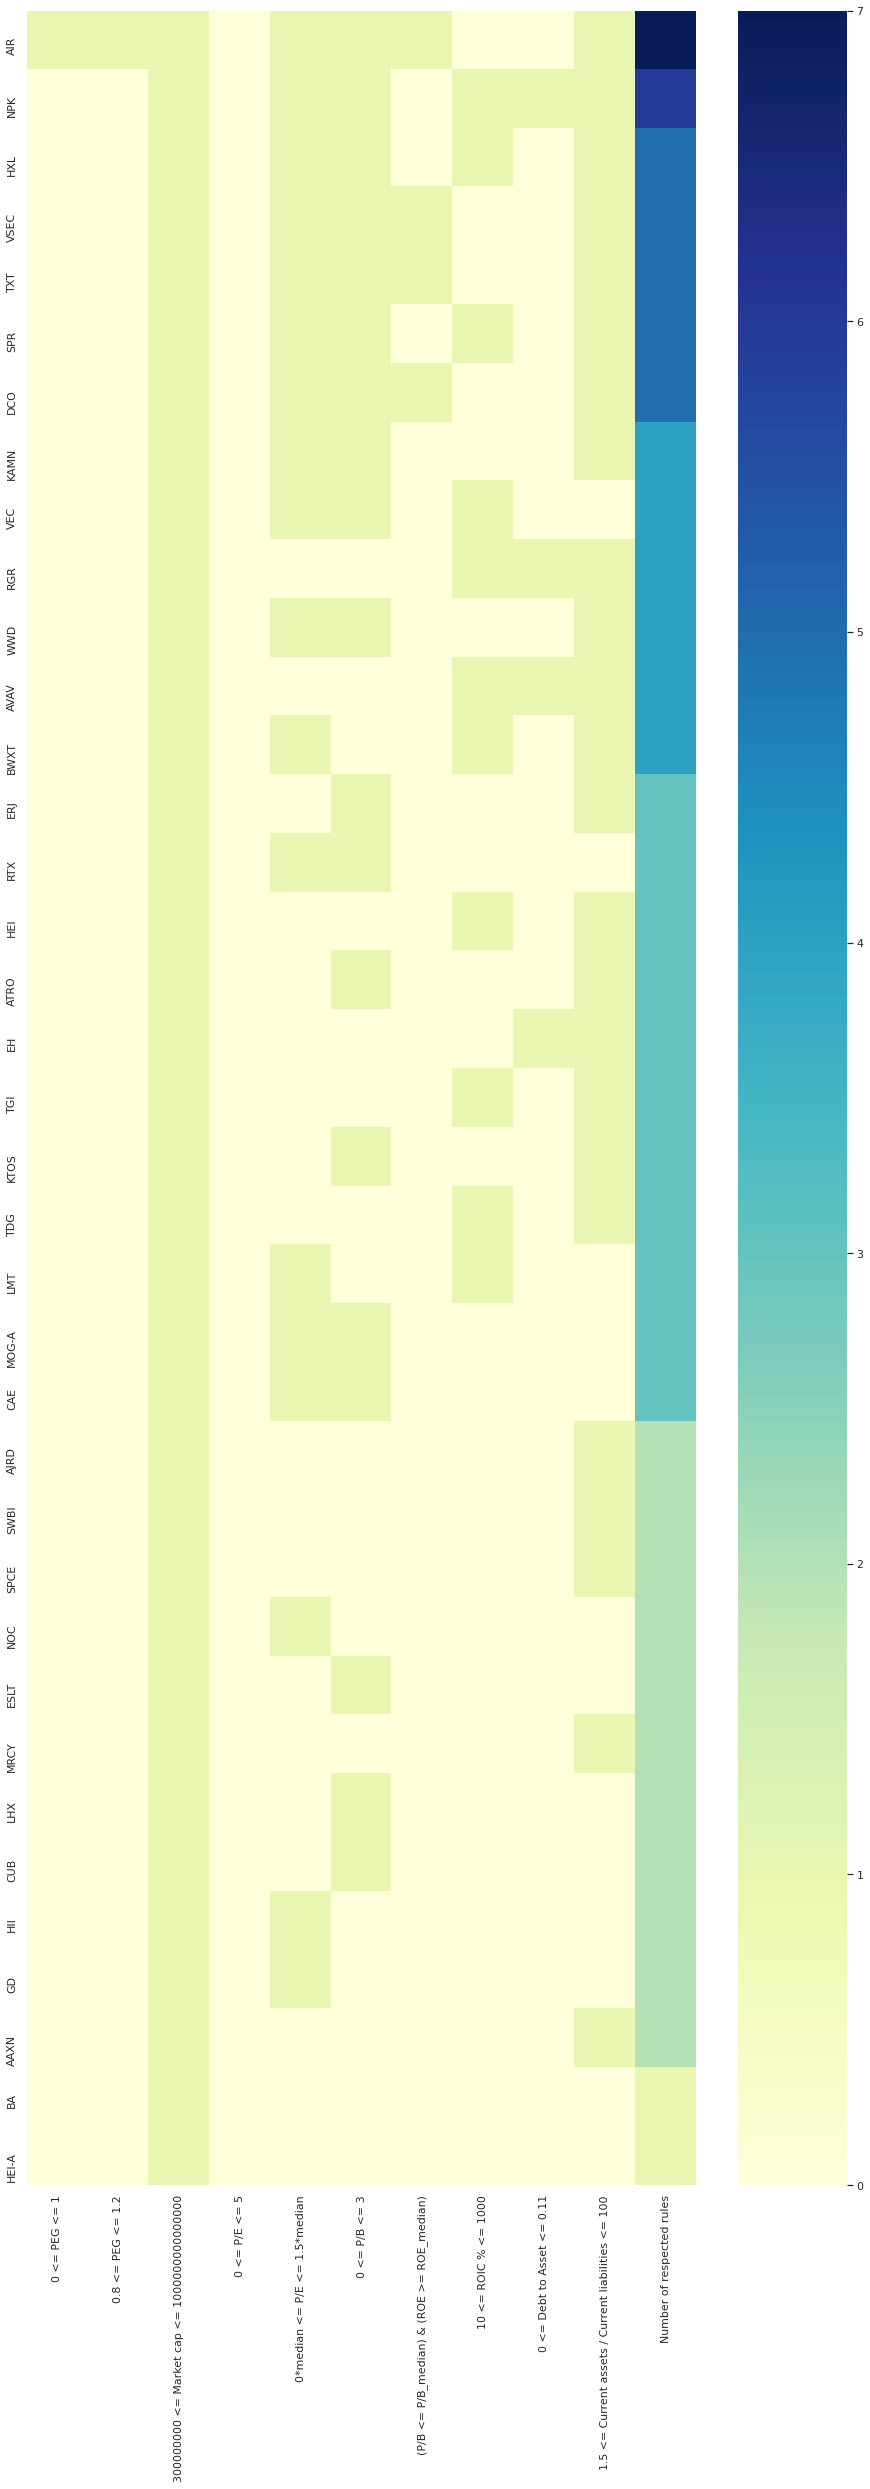

In [ ]:
 # Heatmap: 1 = respect the rule; 0 = do not respect the rule
plt.figure(figsize=(15,40))
ax = sns.heatmap(rules_df, cmap="YlGnBu")

# OLD OR NOT USED

In [ ]:
from finviz.screener import Screener

filters = ['exch_nasd', 'idx_sp500']  # Shows companies in NASDAQ which are in the S&P500
# Get the first 50 results sorted by price ascending
stock_list = Screener(filters=filters, order='price')

# Export the screener results to .csv
stock_list.to_csv()

# Create a SQLite database
stock_list.to_sqlite()

for stock in stock_list[9:19]:  # Loop through 10th - 20th stocks
    print(stock['Ticker'], stock['Price']) # Print symbol and price

# Add more filters
stock_list.add(filters=['fa_div_high'])  # Show stocks with high dividend yield
# or just stock_list(filters=['fa_div_high'])

# Print the table into the console
print(stock_list)

In [ ]:
# NOT USED

def old_scrape_gurufocus_financials(stock_df, to_scrape_td_th_normal, to_scrape_td_tk, to_scrape_td_incent):

  # Create a dataframe whose columns are all the data to scrape from gurufocus Financials
  all_data_to_scrape = to_scrape_td_th_normal + to_scrape_td_tk + to_scrape_td_incent
  df_to_append = pd.DataFrame(columns=all_data_to_scrape)

  # URL link to gurufocus Financials
  token = 'https://www.gurufocus.com/financials/'

  # For each stock symbol, retrieve the HTML code as a BeautifulSoup component
  # for j in tqdm(range(nb_stocks)):
  for j in tqdm(range(1)):
    # Retrieve the stock symbol in the table 'Valuation': 1
    ticker = stock_df[1]['Ticker'][j] 
    print(ticker)
    req = requests.get('https://www.gurufocus.com/financials/' + ticker)
    soup = BeautifulSoup(req.content, 'html.parser')

    # Parse the data
    data_to_parse = {}

    for parameter in to_scrape_td_th_normal:
      td_box = soup.find('td', {'class':'th_normal', 'title': parameter}).find_next('div', {'class': 'td_normal_pershare yesttm'})
      if td_box == None: # class can be 'td_normal_per_share yesttm' or 'td_normal_ratio yesttm'
        td_box = soup.find('td', {'class':'th_normal', 'title': parameter}).find_next('div', {'class': 'td_normal_ratio yesttm'})
      data_to_parse[parameter] = td_box['title']

    return(data_to_parse)

In [ ]:
# NOT USED
def old_get_data_to_scrape_gurufocus_financials():

  req = requests.get('https://www.gurufocus.com/financials/AAPL')
  soup = BeautifulSoup(req.content, 'html.parser')

  to_scrape_td_th_normal = []
  to_scrape_td_tk        = []
  to_scrape_td_incent    = []

  # This data is only for premium members and cannot be scraped
  to_remove_td_th_normal = ['PE Ratio', 'Price-to-Owner-Earnings', 'PB Ratio', 'Price-to-Tangible-Book', 'Price-to-Free-Cash-Flow', 'Price-to-Operating-Cash-Flow', 
               'PS Ratio', 'PEG Ratio', 'EV-to-Revenue', 'EV-to-EBITDA', 'EV-to-EBIT', 'Earnings Yield (Joel Greenblatt) %', 'Forward Rate of Return (Yacktman) %', 
               'Shiller PE Ratio', 'Dividend Yield %', 'Intrinsic Value: Projected FCF', 'Median PS Value', 'Peter Lynch Fair Value', 'Graham Number',
               'Earnings Power Value (EPV)', 'Altman Z-Score', 'Piotroski F-Score', 'Beneish M-Score', 'Scaled Net Operating Assets', 'Sloan Ratio %',
               'Current Ratio', 'Quick Ratio', 'Interest Coverage', 'Highest Stock Price', 'Lowest Stock Price', 'Shares Buyback Ratio %', 'Buyback Yield %',																					
               'YoY Rev. per Sh. Growth', 'YoY EPS Growth', 'YoY EBITDA Growth', '5-Year EBITDA Growth Rate', 'Shares Outstanding (Basic Average)',
               'Shares Outstanding (EOP)', 'Beta', 'Filing Date', 'Restated Filing Date', 'Number of Shareholders', 'Number of Employees',
               'Market Cap', 'Enterprise Value', 'Month End Stock Price', 'Net Cash per Share', 'Net Current Asset Value', 'Net-Net Working Capital']

  all_td_th_normal = soup.find_all('td', {'class': 'th_normal'})
  for td_th_normal in all_td_th_normal:
    to_add = td_th_normal['title']
    if to_add[:2] == '\xa0\xa0':   # Delete the '\xa0\xa0' in the names which corresponds to a tabulation
      to_add = to_add[2:]                     # Removes the '\xa0\xa0' (2 bits)
    to_scrape_td_th_normal = to_scrape_td_th_normal + [to_add]

  all_td_tk = soup.find_all('td', {'class': 'tk'})
  for td_tk in all_td_tk:
    to_add = td_tk['title']
    if to_add[:2] == '\xa0\xa0':   # Delete the '\xa0\xa0' in the names which corresponds to a tabulation
      to_add = to_add[2:]                     # Removes the '\xa0\xa0' (2 bits)
    to_scrape_td_tk = to_scrape_td_tk + [to_add]

  all_td_incent = soup.find_all('td', {'class': 'incent'})
  for td_incent in all_td_incent:
    to_add = td_incent['title']
    if to_add[:2] == '\xa0\xa0':   # Delete the '\xa0\xa0' in the names which corresponds to a space
      to_add = to_add[2:]                     # Removes the '\xa0\xa0' (2 bits)
    to_scrape_td_incent = to_scrape_td_incent + [to_add]

  # Remove the data only accessible to Premium members
  # to_scrape_td_th_normal.remove(to_remove_td_th_normal)

  to_scrape_td_th_normal_final = [ele for ele in to_scrape_td_th_normal if ele not in to_remove_td_th_normal] 
  return(to_scrape_td_th_normal_final, to_scrape_td_tk, to_scrape_td_incent)

to_scrape_td_th_normal, to_scrape_td_tk, to_scrape_td_incent = get_data_to_scrape_gurufocus_financials()

In [ ]:
# Scrape gurufocus


# Extract the parameters of the table Financials from the Excel file Gurufocus Parameters
parameters          = list(gurufocus_financials_parameters['Parameter'])
tag_of_parameters   = list(gurufocus_financials_parameters['Tag of parameter'])
class_of_parameters = list(gurufocus_financials_parameters['Class of parameter'])
tag_of_values       = list(gurufocus_financials_parameters['Tag of value'])
class_of_values     = list(gurufocus_financials_parameters['Class of value'])

# Create a dataframe whose columns are all the data to scrape from gurufocus Financials
df_to_append = pd.DataFrame(columns=parameters)

# URL link to gurufocus Financials
token = 'https://www.gurufocus.com/financials/'

# For each stock symbol, retrieve the HTML code as a BeautifulSoup component
# for j in tqdm(range(nb_stocks)):
  # Retrieve the stock symbol in the table 'Valuation': 1
ticker = 'AAXN'
req = requests.get('https://www.gurufocus.com/financials/' + ticker)
soup = BeautifulSoup(req.content, 'html.parser')

# Parse the data
data_to_parse = {}
# for i, parameter in enumerate(parameters):
i = 10
parameter = parameters[i]
tag_box_test = soup.find(tag_of_parameters[i], {'class': class_of_parameters[i], 'title': parameter})
if tag_box_test == None:  # Case where there are spaces in the html code (&nbsp;&nbsp is \xa0\xa0)
  parameter = '\xa0\xa0' + parameter

tag_box = soup.find(tag_of_parameters[i], {'class': class_of_parameters[i], 'title': parameter})
flag = False

while flag == False:
  tag_box = tag_box.next_sibling
  if tag_box.name == 'td':
    if tag_box.div != None:
      if (tag_box.div['class'] == [class_of_values[i]]):
        data_to_parse[parameter] = tag_box.div['title']
        flag = True 
        # print(tag_box.div)
      # print(tag_box)
    elif tag_box.font != None:
      # elif tag_box.name == 'font':
      if concatenate_list_data(tag_box.font['class']) == class_of_values[i]:
        data_to_parse[parameter] = tag_box.font['title']
        flag = True
  # elif tag_box.name == 'tr':
  #   # print(tag_box)
  #   flag = True

# print(tag_box.name)

  # tag_box = tag_box.next_sibling
# while True:
#   tag_box_next_sibling = tag_box.next_sibling
#   if tag_box_next_sibling.name == 'tr':
#     break
#   else:
#     print(tag_box_next_sibling)

# for child in parent:
#   next_node = child
#   while True:
#     next_node = next_node.next_sibling
#     if next_node.name == 'tr':
#       break
# tag_box = parent.find_next('div', {'class': class_of_values[i]})
# tag_box = soup.find(tag_of_parameters[i], {'class': class_of_parameters[i], 'title': parameter}).find_next(tag_of_values[i], {'class': class_of_values[i]})
# tag_box = soup.find(tag_of_parameters[i], {'class': class_of_parameters[i], 'title': parameter}).find_next_sibling('font', {'class': class_of_values[i]})
# tag_box = soup.find(tag_of_parameters[i], {'class': class_of_parameters[i], 'title': parameter}).find_next_sibling(tag_of_values[i], {'class': class_of_values[i]})
# if tag_box == None:
  # tag_box = soup.find(tag_of_parameters[i], {'class': class_of_parameters[i], 'title': parameter}).find_next_sibling('font', {'class': class_of_values[i]})
  # tag_box = soup.find(tag_of_parameters[i], {'class': class_of_parameters[i], 'title': parameter}).find_next(tag_of_values[i], {'class': class_of_values[i]})
# print(parameters[i], parent)
# data_to_parse[parameter] = tag_box['title']

In [ ]:
# # Scrape gurufocus


# # Create a dataframe whose columns are all the data to scrape from gurufocus Financials
# all_data_to_scrape = to_scrape_td_th_normal + to_scrape_td_tk + to_scrape_td_incent
# df_to_append = pd.DataFrame(columns= all_data_to_scrape)

# # URL link to gurufocus Financials
# token = 'https://www.gurufocus.com/financials/'

# # For each stock symbol, retrieve the HTML code as a BeautifulSoup component
# # for j in tqdm(range(nb_stocks)):
# for j in tqdm(range(1)):
#   # Retrieve the stock symbol in the table 'Valuation': 1
#   ticker = stock_df[1]['Ticker'][j] 
#   print(ticker)
#   req = requests.get('https://www.gurufocus.com/financials/' + ticker)
#   soup = BeautifulSoup(req.content, 'html.parser')

#   # Parse the data
#   data_to_parse = {}

#   for parameter in to_scrape_td_th_normal:
#     td_box = soup.find('td', {'class':'th_normal', 'title': parameter}).find_next('div', {'class': 'td_normal_pershare yesttm'})
#     if td_box == None: # class can be 'td_normal_per_share yesttm' or 'td_normal_ratio yesttm'
#       td_box = soup.find('td', {'class':'th_normal', 'title': parameter}).find_next('div', {'class': 'td_normal_ratio yesttm'})
#     data_to_parse[parameter] = td_box['title']

In [ ]:
# Extract the parameters of the table Financials from the Excel file Gurufocus Parameters
parameters          = list(gurufocus_financials_parameters['Parameter'])
tag_of_parameters   = list(gurufocus_financials_parameters['Tag of parameter'])
class_of_parameters = list(gurufocus_financials_parameters['Class of parameter'])
tag_of_values       = list(gurufocus_financials_parameters['Tag of value'])
class_of_values     = list(gurufocus_financials_parameters['Class of value'])

# Create a dataframe whose columns are all the data to scrape from gurufocus Financials
df_to_append = pd.DataFrame(columns=parameters)
nb_stocks    = len(stock_df[0])

# URL link to gurufocus Financials
token = 'https://www.gurufocus.com/financials/'

# For each stock symbol, retrieve the HTML code as a BeautifulSoup component
# for j in tqdm(range(nb_stocks)):
# Retrieve the stock symbol in the table 'Valuation': 1
ticker = 'AJRD'                    # Retrieve the ticker
req    = requests.get('https://www.gurufocus.com/financials/' + ticker)
soup   = BeautifulSoup(req.content, 'html.parser')

# Parse the data
data_to_parse = {}
for i, parameter in enumerate(parameters):
  tag_box_test = soup.find(tag_of_parameters[i], {'class': class_of_parameters[i], 'title': parameter}) 
  # Locate the part of the html code for the parameter to scrape
  if tag_box_test == None:  
    # Case where there are spaces in the html code (&nbsp;&nbsp is \xa0\xa0)
    tag_box = soup.find(tag_of_parameters[i], {'class': class_of_parameters[i], 'title': '\xa0\xa0' + parameter})
  else:
    tag_box = soup.find(tag_of_parameters[i], {'class': class_of_parameters[i], 'title': parameter})

  # Flag telling not to go too far because find_next finds the first occurence
  # If the parameter value is '--', it is a 'font' not a 'div'
  flag = False
  a = tag_box
  print(i, parameter, type(a))

OLD Yahoo recommendations

In [ ]:
market_index = {'SBF 120'         : '^SBF120', 
                'FTSE 100'        : '^FTSE', 
                'DAX 30'          : '^GDAXI', 
                'Euro Stoxx 50'   : '^STOXX50E', 
                'SMI'             : '^SSMI', 
                'Dow Jones'       : '^DJI', 
                'NASDAQ Composite': '^IXIC'}

# URL link to Yahoo Finance 
lhs_url = 'https://query2.finance.yahoo.com/v10/finance/quoteSummary/'
rhs_url = '?formatted=true&crumb=swg7qs5y9UP&lang=en-US&region=US&' \
              'modules=Components,' \
              'corsDomain=finance.yahoo.com'
      
# Gather the symbols of all the companies inside the stock market index
market_index_symbols = {}  

for key, value in market_index.items():
  url =  lhs_url + value + rhs_url
  r = requests.get(url)
  result = r.json()['quoteSummary']['result'][0]
  market_index_symbols[key] = result['components']['components']

# Add the S&P 500
market_index_symbols['S&P 500'] = si.tickers_sp500()

for key, value in market_index_symbols.items():
  print('{} : {}'.format(key, value))

In [ ]:
# Gather all the companies in European market indices and delete the multiples instances of the same company
EU_market_index = ['SBF 120', 'FTSE 100', 'DAX 30', 'Euro Stoxx 50', 'SMI']
EU_symbols = []
for index in EU_market_index:
  EU_symbols = EU_symbols + market_index_symbols[index]
EU_symbols = np.unique(EU_symbols)

# Gather all the companies in American market indices and delete the multiples instances of the same company
US_market_index = ['Dow Jones', 'NASDAQ Composite', 'S&P 500']
US_symbols = []
for index in US_market_index:
  US_symbols = US_symbols + market_index_symbols[index]
US_symbols = np.unique(US_symbols)

In [ ]:
# Analysts' recommendations for the European stock markets

EU_recommendations = get_recommendations(EU_symbols)

In [ ]:
# Analysts' recommendations for the US stock markets

US_recommendations = get_recommendations(US_symbols)

In [ ]:
# US stock market: Filter for the recommendation
# Variable: Recommendation <= filter

filter = 1.2

US_recommendations_filter = US_recommendations.iloc[np.where(US_recommendations['Recommendations'] <= filter)]

# EU stock market: Filter for the recommendation
# Variable: Recommendation <= filter

EU_recommendations_filter = EU_recommendations.iloc[np.where(EU_recommendations['Recommendations'] <= filter)]  

recommendations = US_recommendations_filter.append(EU_recommendations_filter)